In [10]:
import warnings
from socceraction.data.wyscout import WyscoutLoader
from socceraction.spadl.wyscout import convert_to_actions
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
# import XGBclassifier
import numpy as np
from xgboost import XGBClassifier
#from scikitplot.metrics import plot_calibration_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scikitplot.metrics import plot_calibration_curve


In [11]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [12]:
def load_environment_vars():
    # Get the current working directory
    cwd = os.getcwd()

    # Append the .env file name
    env_path = os.path.join(cwd, '../.env')

    # Open the .env file
    with open(env_path) as f:
        # Read the lines
        lines = f.readlines()

    # Parse the key-value pairs
    for line in lines:
        # Ignore comments and empty lines
        if line.startswith('#') or not line.strip():
            continue
        # Split the line into key and value
        key, value = line.strip().split('=', 1)
        # Set the environment variable
        os.environ[key] = value

    return os.environ['WYSCOUT_API_USER'], os.environ['WYSCOUT_API_PASSWORD']

#def create_wyscout_client(username, password):
#    return wyscoutapi.WyscoutAPI(username=username, password=password)

In [13]:
# set authentication credentials as environment variables
username, password = load_environment_vars()

# or provide authentication credentials as a dictionary
api = WyscoutLoader(getter="remote", creds={"user":username, "passwd": password})

In [14]:
api.competitions(108)

,competition_id,competition_name,country_name,competition_gender,season_id,season_name
0,108,UEFA Champions League,Europe,male,189928,2024/2025
1,108,UEFA Champions League,Europe,male,188921,2023/2024
2,108,UEFA Champions League,Europe,male,188032,2022/2023
3,108,UEFA Champions League,Europe,male,187412,2021/2022
4,108,UEFA Champions League,Europe,male,186203,2020/2021
5,108,UEFA Champions League,Europe,male,185516,2019/2020
6,108,UEFA Champions League,Europe,male,185428,2018/2019
7,108,UEFA Champions League,Europe,male,181371,2017/2018
8,108,UEFA Champions League,Europe,male,10748,2016/2017
9,108,UEFA Champions League,Europe,male,9498,2015/2016


In [ ]:
api.games(108,189928)

In [17]:
mad_mun = api.events(5467184)

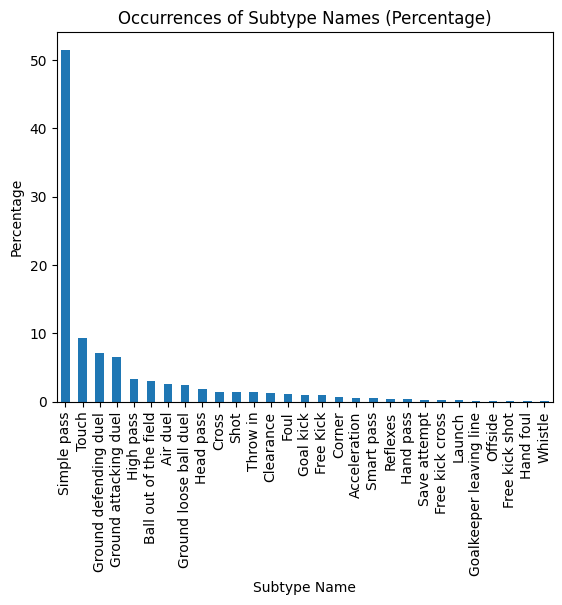

In [23]:
subtype_counts = mad_mun['subtype_name'].value_counts()
subtype_percentages = subtype_counts / subtype_counts.sum() * 100

subtype_percentages.plot(kind='bar')
plt.xlabel('Subtype Name')
plt.ylabel('Percentage')
plt.title('Occurrences of Subtype Names (Percentage)')
plt.show()

In [24]:
mad_mun['x_start'] = [x[0]['x'] for x in mad_mun['positions']]
mad_mun['y_start'] = [x[0]['y'] for x in mad_mun['positions']]

In [30]:
import matplotlib.pyplot as plt 
from matplotlib.patches import Ellipse
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import seaborn as sns
from collections import Counter
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go


def pitch():
    """
    code to plot a soccer pitch 
    """
    #create figure
    fig,ax=plt.subplots(figsize=(7,5))
    
    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,100], color="black")
    plt.plot([0,100],[100,100], color="black")
    plt.plot([100,100],[100,0], color="black")
    plt.plot([100,0],[0,0], color="black")
    plt.plot([50,50],[0,100], color="black")

    #Left Penalty Area
    plt.plot([16.5,16.5],[80,20],color="black")
    plt.plot([0,16.5],[80,80],color="black")
    plt.plot([16.5,0],[20,20],color="black")

    #Right Penalty Area
    plt.plot([83.5,100],[80,80],color="black")
    plt.plot([83.5,83.5],[80,20],color="black")
    plt.plot([83.5,100],[20,20],color="black")

    #Left 6-yard Box
    plt.plot([0,5.5],[65,65],color="black")
    plt.plot([5.5,5.5],[65,35],color="black")
    plt.plot([5.5,0.5],[35,35],color="black")

    #Right 6-yard Box
    plt.plot([100,94.5],[65,65],color="black")
    plt.plot([94.5,94.5],[65,35],color="black")
    plt.plot([94.5,100],[35,35],color="black")

    #Prepare Circles
    centreCircle = Ellipse((50, 50), width=30, height=39, edgecolor="black", facecolor="None", lw=1.8)
    centreSpot = Ellipse((50, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)
    leftPenSpot = Ellipse((11, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)
    rightPenSpot = Ellipse((89, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #limit axis
    plt.xlim(0,100)
    plt.ylim(0,100)
    
    ax.annotate("", xy=(25, 5), xytext=(5, 5),
                arrowprops=dict(arrowstyle="->", linewidth=2))
    ax.text(7,7,'Attack',fontsize=20)
    return fig,ax

def draw_pitch(pitch, line, orientation, view, alpha=1):
    """
    Draw a soccer pitch given the pitch, the orientation, the view and the line
    
    Parameters
    ----------
    pitch
    
    """
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)

        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=alpha)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=alpha)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=alpha)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=alpha)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=alpha)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=alpha)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)


def get_pitch_layout(title):
    lines_color = 'black'
    bg_color = 'rgb(255, 255, 255)'
    pitch_layout = dict(hovermode='closest', autosize=False,
                                        width=825,
                                        height=600,
                                        plot_bgcolor=bg_color,#'rgb(59,205,55)',
                                        xaxis={
                                            'range': [0, 100],
                                            'showgrid': False,
                                            'showticklabels': False,
                                        },
                                        yaxis={
                                            'range': [0, 100],
                                            'showgrid': False,
                                            'showticklabels': False,
                                        },
                                        title=title,
                                        shapes=[
                                            {
                                                'type': 'circle',
                                                'xref': 'x',
                                                'yref': 'y',
                                                'y0': 35,
                                                'x0': 40,
                                                'y1': 65,
                                                'x1': 60,
                                                'line': {
                                                    'color': lines_color,
                                                },

                                            },
                                         {
                                                'type': 'line',
                                                'xref': 'x',
                                                'yref': 'y',
                                                'y0': 35,
                                                'x0': 0,
                                                'y1': 35,
                                                'x1': 10,                                         
                                                'line': {
                                                    'color': lines_color,
                                                },

                                            },
                                         {
                                                'type': 'line',
                                                'xref': 'x',
                                                'yref': 'y',
                                                'y0': 35,
                                                'x0': 10,
                                                'y1': 65,
                                                'x1': 10,
                                                'line': {
                                                    'color': lines_color,
                                                }
                                         },
                                        {
                                            'type': 'line',
                                            'xref': 'x',
                                            'yref': 'y',
                                            'y0': 65,
                                            'x0': 10,
                                            'y1': 65,
                                            'x1': 0,
                                            'line': {
                                                'color': lines_color,
                                            }
                                          },
                                        {
                                                'type': 'line',
                                                'xref': 'x',
                                                'yref': 'y',
                                                'y0': 35,
                                                'x0': 100,
                                                'y1': 35,
                                                'x1': 90,                                         
                                                'line': {
                                                    'color': lines_color,
                                                },

                                            },
                                         {
                                                'type': 'line',
                                                'xref': 'x',
                                                'yref': 'y',
                                                'y0': 35,
                                                'x0': 90,
                                                'y1': 65,
                                                'x1': 90,
                                                'line': {
                                                    'color': lines_color,
                                                }
                                         },
                                        {
                                            'type': 'line',
                                            'xref': 'x',
                                            'yref': 'y',
                                            'y0': 65,
                                            'x0': 90,
                                            'y1': 65,
                                            'x1': 100,
                                            'line': {
                                                'color': lines_color,
                                            }
                                          },    
                                        {
                                            'type': 'line',
                                            'xref': 'x',
                                            'yref': 'y',
                                            'y0': 100,
                                            'x0': 50,
                                            'y1': 0,
                                            'x1': 50,
                                            'line': {
                                                'color': lines_color,
                                            }
                                          },
                                        {
                                            'type': 'line',
                                            'xref': 'x',
                                            'yref': 'y',
                                            'y0': 0,
                                            'x0': 0,
                                            'y1': 100,
                                            'x1': 0,
                                            'line': {
                                                'color': lines_color,
                                            }
                                          },
                                        {
                                            'type': 'line',
                                            'xref': 'x',
                                            'yref': 'y',
                                            'y0': 0,
                                            'x0': 100,
                                            'y1': 100,
                                            'x1': 100,
                                            'line': {
                                                'color': lines_color,
                                            }
                                          },
                                        {
                                            'type': 'line',
                                            'xref': 'x',
                                            'yref': 'y',
                                            'y0': 100,
                                            'x0': 0,
                                            'y1': 100,
                                            'x1': 100,
                                            'line': {
                                                'color': lines_color,
                                            }
                                          },
                                        {
                                            'type': 'line',
                                            'xref': 'x',
                                            'yref': 'y',
                                            'y0': 0,
                                            'x0': 0,
                                            'y1': 0,
                                            'x1': 100,
                                            'line': {
                                                'color': lines_color,
                                            }
                                          },
                                        ]
    )
    return pitch_layout  

In [40]:
team_names = api.teams(5467184)

In [50]:
team_dict = team_names.set_index('team_id')['team_name_short'].to_dict()
team_names[['team_id', 'team_name_short']]

,team_id,team_name_short
0,675,Real Madrid
1,2444,Bayern München


In [51]:
team_dict

{675: 'Real Madrid', 2444: 'Bayern München'}

In [35]:
mad_mun['team_id'].unique()

array([2444,  675])

In [55]:
match_label = "Semi-finals"

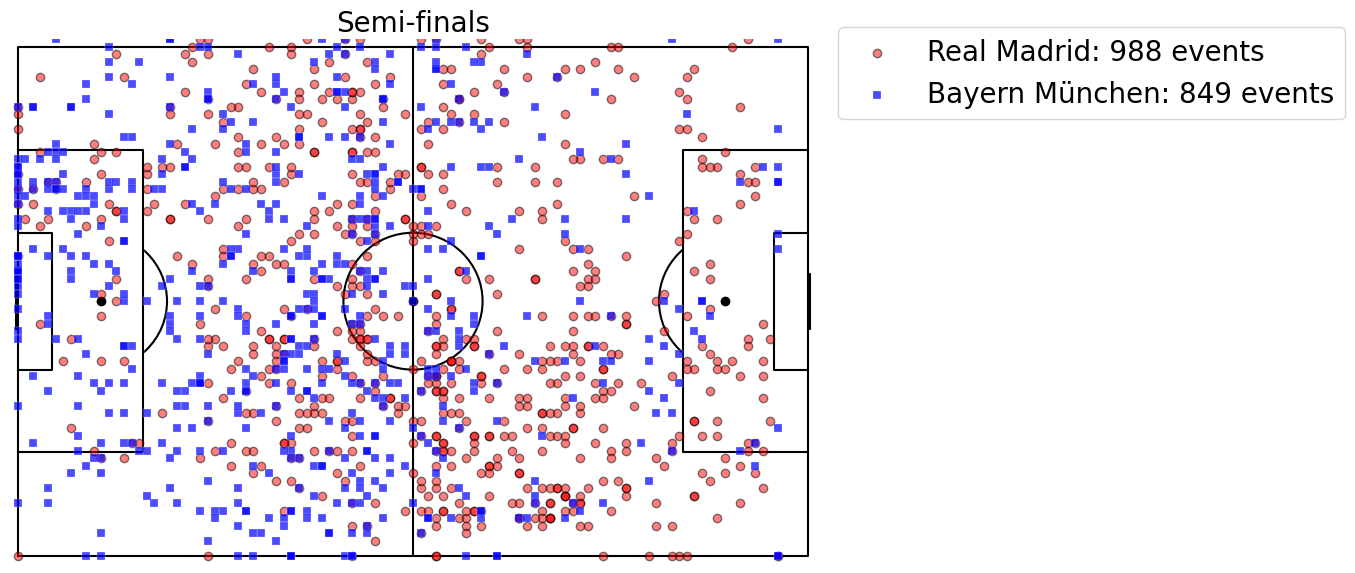

In [57]:
team_1, team_2 = np.unique(mad_mun['team_id'])
df_team_1 = mad_mun[mad_mun['team_id'] == team_1]
df_team_2 = mad_mun[mad_mun['team_id'] == team_2]

f = draw_pitch("white", "black", "h", "full")
plt.scatter(df_team_1['x_start'], df_team_1['y_start'], c='red', edgecolors="k", zorder=12, 
            alpha=0.5, label='%s: %s events' %(team_dict[team_1], len(df_team_1)))
plt.scatter(df_team_2['x_start'], df_team_2['y_start'], marker='s', c='blue', edgecolors="w", linewidth=0.25, zorder=12, 
            alpha=0.7, label='%s: %s events' %(team_dict[team_2], len(df_team_2)))
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
plt.title(match_label, fontsize=20)
plt.show()

In [21]:
mad_mun['subtype_name']

0                 Simple pass
1                   High pass
2                 Simple pass
3       Ground attacking duel
4       Ground defending duel
                ...          
1832                Head pass
1833    Ground defending duel
1834    Ground attacking duel
1835                     Foul
1836                Free Kick
Name: subtype_name, Length: 1837, dtype: object

In [5]:
last_premier_games = api.games(364,188989)

In [6]:
last_premier_games

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,5465267,364,188989,2024-05-06 19:00:00,36,1628,1611
1,5465268,364,188989,2024-05-05 15:30:00,36,1612,1624
2,5465264,364,188989,2024-05-05 13:00:00,36,1651,1614
3,5465266,364,188989,2024-05-05 13:00:00,36,1610,1633
4,5465270,364,188989,2024-05-04 16:30:00,36,1625,1629
...,...,...,...,...,...,...,...
352,5464915,364,188989,2023-08-12 14:00:00,1,1651,1660
353,5464916,364,188989,2023-08-12 14:00:00,1,1623,1616
354,5464917,364,188989,2023-08-12 14:00:00,1,1636,1628
355,5464913,364,188989,2023-08-12 12:00:00,1,1609,1642


In [52]:
last_games = last_premier_games	

In [53]:
last_games

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,5465116,364,188989,2024-01-12 19:45:00,21,1646,1660
1,5465110,364,188989,2024-01-02 19:30:00,20,1633,1651
2,5465105,364,188989,2024-01-01 20:00:00,20,1612,1613
3,5465104,364,188989,2023-12-31 14:00:00,20,1616,1609
4,5465109,364,188989,2023-12-31 14:00:00,20,1624,1659
...,...,...,...,...,...,...,...
194,5464915,364,188989,2023-08-12 14:00:00,1,1651,1660
195,5464916,364,188989,2023-08-12 14:00:00,1,1623,1616
196,5464917,364,188989,2023-08-12 14:00:00,1,1636,1628
197,5464913,364,188989,2023-08-12 12:00:00,1,1609,1642


If we evaluate new games we need to update our features data

In [ ]:
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

functions_labels = [
    labels.scores,
    labels.concedes
]

for game_id, home_team_id in zip(last_games['game_id'].values, last_games['home_team_id'].values):
    print(f'Processing game {game_id}')
    last_game_event = api.events(game_id)
    spadl_df = convert_to_actions(last_game_event, home_team_id)
    team_name = api.teams(game_id=game_id)
    team_name.to_hdf('teams.h5', key=f'game_{game_id}')

    player_name = api.players(game_id=game_id)
    player_name.to_hdf('players.h5', key=f'game_{game_id}')

    df_actions = (spadl.add_names(spadl_df))  # add actiontype and result names
                  
    gamestates = features.gamestates(df_actions,3)
    gamestates = features.play_left_to_right(gamestates, home_team_id)

    #df_actions = (
    #spadl
    #.add_names(spadl_df)  # add actiontype and result names
    #.merge(team_name)  # add team names
    #.merge(player_name)  # add player names
    #)
    df_actions.to_hdf('actions.h5', key=f'game_{game_id}')

    #df_actions_atomic = atomicspadl.convert_to_atomic(df_actions)
    #df_actions_atomic = (
    #    atomicspadl
    #    .add_names(df_actions)  # add actiontype and result names
    #    .merge(team_name)  # add team names
    #    .merge(player_name)  # add player names
    #    )
    #df_actions_atomic.to_hdf('atomic_actions.h5', key=f'game_{game_id}')
    
    #gamestates = features.gamestates(df_actions,3)
    #gamestates = features.play_left_to_right(gamestates, home_team_id)

    df_features = pd.concat([fn(gamestates) for fn in functions_features], axis=1)
    df_features.to_hdf('features.h5', key=f'game_{game_id}')
    # 3. compute labels
    df_labels = pd.concat([fn(df_actions) for fn in functions_labels], axis=1)
    df_labels.to_hdf('labels.h5', key=f'game_{game_id}')

# Load label and features

In [55]:
dfs_features = []
dfs_labels = []
for game_id, home_team_id in zip(last_games['game_id'].values, last_games['home_team_id'].values):
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    df_features['game_id'] = game_id
    dfs_features.append(df_features)

    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    df_labels['game_id'] = game_id
    dfs_labels.append(df_labels)
    
df_labels = pd.concat(dfs_labels).reset_index(drop=True)
df_features = pd.concat(dfs_features).reset_index(drop=True)

In [56]:
df_labels.tail()

,scores,concedes,game_id
264696,False,False,5464912
264697,False,False,5464912
264698,False,False,5464912
264699,False,False,5464912
264700,False,False,5464912


In [57]:
df_features.tail(10)

,actiontype_pass_a0,actiontype_cross_a0,actiontype_throw_in_a0,actiontype_freekick_crossed_a0,actiontype_freekick_short_a0,actiontype_corner_crossed_a0,actiontype_corner_short_a0,actiontype_take_on_a0,actiontype_foul_a0,actiontype_tackle_a0,...,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2,game_id
264691,True,False,False,False,False,False,False,False,False,False,...,0.041314,90.091733,0.298793,77.269425,0.426424,True,False,2.0,8.0,5464912
264692,True,False,False,False,False,False,False,False,False,False,...,0.100587,98.784292,0.041314,90.091733,0.298793,True,True,5.0,7.0,5464912
264693,True,False,False,False,False,False,False,False,False,False,...,0.000000,81.260741,0.100587,98.784292,0.041314,True,True,45.0,50.0,5464912
264694,True,False,False,False,False,False,False,False,False,False,...,0.215642,77.700000,0.000000,81.260741,0.100587,True,True,5.0,50.0,5464912
264695,True,False,False,False,False,False,False,False,False,False,...,0.299569,73.092883,0.215642,77.700000,0.000000,True,True,3.0,8.0,5464912
264696,True,False,False,False,False,False,False,False,False,False,...,0.130652,71.431288,0.299569,73.092883,0.215642,True,True,6.0,9.0,5464912
264697,True,False,False,False,False,False,False,False,False,False,...,0.187588,73.072792,0.130652,71.431288,0.299569,True,True,1.0,7.0,5464912
264698,True,False,False,False,False,False,False,False,False,False,...,0.096360,61.987447,0.187588,73.072792,0.130652,True,True,7.0,8.0,5464912
264699,True,False,False,False,False,False,False,False,False,False,...,0.234217,70.677878,0.096360,61.987447,0.187588,True,True,3.0,10.0,5464912
264700,True,False,False,False,False,False,False,False,False,False,...,0.234217,61.530000,0.234217,70.677878,0.096360,True,True,3.0,6.0,5464912


# Split the dataset

- Stratification: we want to keep the same distribution of classes in the train and test set, since we have two different class labels we provided a concatenation of the two labels to the stratify parameter.

In [58]:
df_labels['concedes'].value_counts()

concedes
False    263178
True       1523
Name: count, dtype: int64

In [59]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df_features,
    df_labels,
    test_size=0.1,
    random_state=42,
    stratify=df_labels['scores'].astype(str) + '_' + df_labels['concedes'].astype(str)
)

In [60]:
df_y_train['scores'].mean()

0.01663518448558116

In [61]:
df_y_test['scores'].mean()

0.016621963658343092

In [62]:
df_y_train['concedes'].mean()

0.0057549427024304245

In [63]:
df_y_test['concedes'].mean()

0.005742132900154887

**Note**: In a real-world scenario where more data is available, you should consider respecting the chronological order of the games to construct the training set, validation set and test set. For instance, use the data for the 2016/2017 and 2017/2018 seasons to train the models, use the data for the 2018/2019 season to tune the models, and use the data for the 2019/2020 season to obtain the results.

## Construct baseline classfiers

In [89]:
features = [
    'start_dist_to_goal_a0',
    'end_dist_to_goal_a0',
    'start_dist_to_goal_a1',
    'end_dist_to_goal_a1',
    'start_dist_to_goal_a2',
    'end_dist_to_goal_a2',
    'start_angle_to_goal_a0',
    'end_angle_to_goal_a0',
    'start_angle_to_goal_a1',
    'end_angle_to_goal_a1',
    'start_angle_to_goal_a2',
    'end_angle_to_goal_a2',
    'team_1',
    'team_2'
]

In [85]:
labels = ['scores',
          #'concedes'
          ]

## Train classifier

In [107]:
%%time

models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        n_estimators = 10,
        max_depth = 3

    )

    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
        )
    models[label] = model

100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

CPU times: user 1.03 s, sys: 20.1 ms, total: 1.05 s
Wall time: 432 ms


## 4.2 Estimate the probabilities

In [108]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1)

100%|██████████| 1/1 [00:00<00:00, 36.19it/s]


In [109]:
df_predictions.head(10)

,scores
173282,0.010018
108467,0.033707
158101,0.021471
202342,0.019573
239227,0.010018
28748,0.013241
168668,0.015045
157030,0.014535
161053,0.021471
18458,0.061417


## 4.3 Evaluate the probabilities

### 4.3.1 Compute base rate probabilities

The following cell computes the base rate or prior probability of each class label in the training set. We use the base rate as a naive estimate for each example in the test set being true to establish a baseline for the evaluation metrics.

The `np.full()` function in NumPy is used to create a new array of given shape and type, filled with a fill value. Here's the syntax of the `np.full()` function:

```python
numpy.full(shape, fill_value, dtype=None, order='C')
```

Parameters:

- `shape`: Shape of the new array, e.g., `(2, 3)` or `2`.
- `fill_value`: Fill value.
- `dtype` (optional): The desired data type for the array. If not given, then the type will be determined as the minimum type required to hold the objects in the sequence.
- `order` (optional): Whether to store multidimensional data in row-major (C-style) or column-major (Fortran-style) order in memory.

Here's an example of how to use the `np.full()` function:

```python
import numpy as np

# Create a new 2x3 array filled with 7
arr = np.full((2, 3), 7)

print(arr)
```

Output:

```
[[7 7 7]
 [7 7 7]]
```

In this example, `np.full((2, 3), 7)` creates a new 2x3 array filled with 7.

In [110]:
df_base_rates = pd.DataFrame({
    label:np.full(len(df_y_test[label]), df_y_train[label].mean()) for label in labels
    })

In [111]:
df_base_rates.head()

,scores
0,0.016635
1,0.016635
2,0.016635
3,0.016635
4,0.016635


## 4.3.2 Compute Brier score loss for goal scored model

In [112]:
from sklearn.metrics import brier_score_loss, roc_auc_score

The following computes the Brier loss score for the base rate predictions

In [113]:
brier_score_loss(
    y_true = df_y_test['scores'],
    y_prob = df_base_rates['scores']
)

0.016345674157274084

The following computes the Brier loss score for the prediction by the learned model.

In [114]:
brier_score_loss(
    y_true = df_y_test['scores'],
    y_prob = df_predictions['scores']
)

0.01508935457762824

We can also make the same calculation for conceded goals

In [ ]:
#brier_score_loss(
#    y_true = df_y_test['conceded'],
#    y_prob = df_base_rates['conceded']
#)

#brier_score_loss(
#    y_true = df_y_test['conceded'],
#    y_prob = df_predictions['conceded']
#)

## 4.3.4 Plot the calibration curve and probability histogram

In [115]:
from scikitplot.metrics import plot_calibration_curve

<Axes: ylabel='Frequency'>

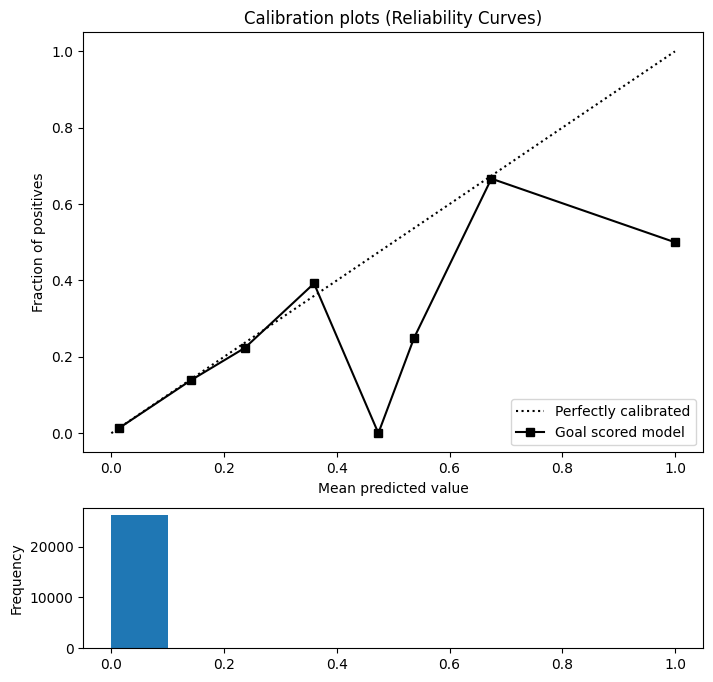

In [116]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={'height_ratios':[3, 1]
    }
)
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1
)

df_predictions['scores'].plot.hist(
    range=(0, 1),
    bins=10,
    ax=ax2
)

# 5 Optimize classifiers

In [117]:
labels

['scores']

In [118]:
features

['start_dist_to_goal_a0',
 'end_dist_to_goal_a0',
 'start_dist_to_goal_a1',
 'end_dist_to_goal_a1',
 'start_dist_to_goal_a2',
 'end_dist_to_goal_a2',
 'start_angle_to_goal_a0',
 'end_angle_to_goal_a0',
 'start_angle_to_goal_a1',
 'end_angle_to_goal_a1',
 'start_angle_to_goal_a2',
 'end_angle_to_goal_a2',
 'team_1',
 'team_2']

In [125]:
%%time
models_cv = {}
for label in tqdm(labels):
    model_cv = GridSearchCV(
        estimator=XGBClassifier(
            eval_metric='logloss',
            use_label_encoder=False,
        ),
        param_grid={
            'n_estimators': [50, 100],
            'max_depth': [3, 4]
        },
        scoring='neg_brier_score',
        refit=True,  # train final model on full training set using best hyperparameters
        verbose=10,
        n_jobs=1
    )
    model_cv.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models_cv[label] = model_cv

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 1/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.015 total time=   0.6s
[CV 2/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 2/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.015 total time=   0.6s
[CV 3/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 3/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.015 total time=   0.6s
[CV 4/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 4/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.015 total time=   0.5s
[CV 5/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 5/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.015 total time=   0.5s
[CV 1/5; 2/4] START max_depth=3, n_estimators=100...............................
[CV 1/5; 2/4] END max_depth=3, n_estimators=100;,

100%|██████████| 1/1 [00:14<00:00, 14.54s/it]

CPU times: user 45.6 s, sys: 440 ms, total: 46.1 s
Wall time: 14.5 s


**Note**: We have considered a manually selected set of features to represent the game states. In addition to optimizing the hyperparameters for the learning algorithm, we could also optimize the set of features to be considered by the learning algorithm. However, the XGBoost algorithm should be able to figure out by itself which features are most important to include in the model by the nature of the algorithm.

## Estimate probabilities
The following cell estimates the probabilities for each label using the trained baseline models.

In [126]:
dfs_predictions_cv = {}
for label in tqdm(labels):
    model_cv = models_cv[label]
    probabilities_cv = model_cv.predict_proba(
        df_X_test[features]
    )
    predictions_cv = probabilities_cv[:, 1]
    dfs_predictions_cv[label] = pd.Series(predictions_cv, index=df_X_test.index)
df_predictions_cv = pd.concat(dfs_predictions_cv, axis=1)

100%|██████████| 1/1 [00:00<00:00, 29.99it/s]


## Evaluate probabilities
Compute Brier score loss for goal scored model
The following cell computes the Brier loss score for the base rate predictions.

In [127]:
df_predictions_cv

,scores
173282,0.006048
108467,0.018980
158101,0.018011
202342,0.012674
239227,0.002950
...,...
34893,0.009223
172422,0.003619
16038,0.019519
240169,0.048216


In [128]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_base_rates['scores']
)

0.016345674157274084

In [129]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_predictions_cv['scores']
)

0.014939322764307632

## Plot calibration curve and probability histogram
The following cell creates a plot to show both a calibration curve and a probability histogram.

<Axes: ylabel='Frequency'>

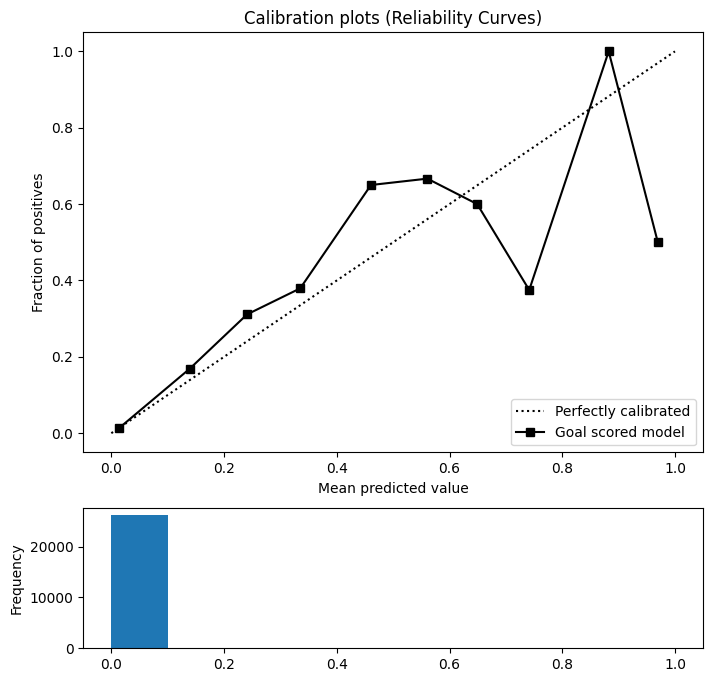

In [130]:
fig_cv, (ax1_cv, ax2_cv) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={
        'height_ratios': [3, 1]
    }
)

plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions_cv['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1_cv
)

df_predictions_cv['scores'].plot.hist(
    range=(0, 1),
    bins=10,
    ax=ax2_cv
)

### Optional: Calibrate probabilities

If the trained model produces poorly calibrated probability estimates, the probability estimates can be re-calibrated using ``CalibratedClassifierCV``, which performs probability calibration with isotonic regression or logistic regression.

### Construct final classifiers
Once we have found the best feature set and best hyperparameters for the learning algorithm, we can learn the final model.

If we use GridSearchCV and the refit parameter was set to True, we can retrieve the final model, which has been re-trained on the entire training set, by accessing the best_estimator_ attribute of the object.
We can manually train the final model by creating a XGBClassifier object using the best hyperparameters and calling the fit method with the entire training set.

### Option 1: Retrieve classifier from grid search

In [131]:
model_scores = models_cv['scores']

In [132]:
pd.Series(
    model_scores.best_params_
)

max_depth        3
n_estimators    50
dtype: int64

In [133]:
pd.DataFrame(
    model_scores.cv_results_
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.520530,0.041532,0.043542,0.000666,3,50,"{'max_depth': 3, 'n_estimators': 50}",-0.015245,-0.015141,-0.015237,-0.015393,-0.015278,-0.015259,0.000081,1
1,0.709852,0.028617,0.049815,0.000813,3,100,"{'max_depth': 3, 'n_estimators': 100}",-0.015262,-0.015152,-0.015255,-0.015425,-0.015354,-0.015290,0.000093,2
2,0.552396,0.011591,0.046688,0.000739,4,50,"{'max_depth': 4, 'n_estimators': 50}",-0.015266,-0.015147,-0.015313,-0.015441,-0.015342,-0.015302,0.000096,3
3,0.795461,0.050197,0.056129,0.000383,4,100,"{'max_depth': 4, 'n_estimators': 100}",-0.015304,-0.015243,-0.015360,-0.015471,-0.015461,-0.015368,0.000089,4


In [134]:
pd.Series(
    model_scores.best_estimator_.get_params()
)

objective                  binary:logistic
base_score                            None
booster                               None
callbacks                             None
colsample_bylevel                     None
colsample_bynode                      None
colsample_bytree                      None
device                                None
early_stopping_rounds                 None
enable_categorical                   False
eval_metric                        logloss
feature_types                         None
gamma                                 None
grow_policy                           None
importance_type                       None
interaction_constraints               None
learning_rate                         None
max_bin                               None
max_cat_threshold                     None
max_cat_to_onehot                     None
max_delta_step                        None
max_depth                                3
max_leaves                            None
min_child_w

In [135]:
model_scores_final = model_scores.best_estimator_

In [136]:
model_scores_final

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Option 2: Train classifier using optimal hyperparameters
The following cell constructs a new XGBoostClassifier object using the best hyperparameters that were found by the grid search.

In [137]:
model_scores_final = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=50,
    max_depth=3
)

In [138]:
model_scores_final.fit(
    X=df_X_train[features],
    y=df_y_train[label]
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)